# Binary Classification
Uses transcript to predict presence of depression. Recall that a PHQ_Score of 10 and above is considered as depression.

# Import necessary modules

In [1]:
!pip install -U imbalanced-learn

# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Processing
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from imblearn.under_sampling import RandomUnderSampler

# Metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import f1_score

# Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Neural networks
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Embedding, Flatten
from keras.initializers import Constant
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

Requirement already up-to-date: imbalanced-learn in /opt/conda/lib/python3.6/site-packages (0.7.0)


Using TensorFlow backend.


# Handle Imbalanced Dataset

## Exploratory Data Analysis

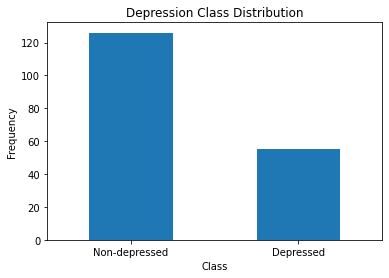

The ratio of negative to positive cases is 2.29.


In [2]:
df = pd.read_csv("../../data/clean_compiled_transcripts.csv")

count_classes = pd.value_counts(df.PHQ_Binary)
count_classes.plot(kind = 'bar', rot=0)
labels = ["Non-depressed", "Depressed"]

plt.title("Depression Class Distribution")
plt.xticks(range(2), labels)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

print(f"The ratio of negative to positive cases is {round(count_classes[0] / count_classes[1], 2)}.")

Clearly, the dataset is highly imbalanced and is likely to result in poor performance. We should strive for 50:50 during training.

## Convert transcripts to padded sequences

In [3]:
RANDOM_STATE = 42 # lucky number

X = df.Transcript
y = df.PHQ_Binary

In [4]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
vocab_size = len(tokenizer.word_index) + 1

tokenizer.word_index

{'i': 1,
 'um': 2,
 'it': 3,
 'uh': 4,
 'you': 5,
 'my': 6,
 'know': 7,
 'like': 8,
 'me': 9,
 'really': 10,
 'would': 11,
 'yeah': 12,
 'think': 13,
 'they': 14,
 'people': 15,
 'well': 16,
 'good': 17,
 'we': 18,
 'things': 19,
 'get': 20,
 'lot': 21,
 'time': 22,
 'go': 23,
 'she': 24,
 'he': 25,
 'pretty': 26,
 'going': 27,
 'one': 28,
 'probably': 29,
 'them': 30,
 'little': 31,
 'life': 32,
 'something': 33,
 'say': 34,
 'could': 35,
 'mm': 36,
 'feel': 37,
 'guess': 38,
 'much': 39,
 'years': 40,
 'mean': 41,
 'different': 42,
 'yes': 43,
 'kinda': 44,
 'myself': 45,
 'back': 46,
 'want': 47,
 'oh': 48,
 'see': 49,
 'right': 50,
 'got': 51,
 'sometimes': 52,
 'her': 53,
 'always': 54,
 'went': 55,
 'hard': 56,
 'ago': 57,
 'work': 58,
 'okay': 59,
 'kind': 60,
 'school': 61,
 'try': 62,
 'family': 63,
 'maybe': 64,
 'love': 65,
 'actually': 66,
 'make': 67,
 'day': 68,
 'friends': 69,
 'happy': 70,
 'way': 71,
 'thing': 72,
 'anything': 73,
 'last': 74,
 'job': 75,
 'two': 76,
 

In [5]:
maxlen = 1000

def prepare(X):
    X_seq = tokenizer.texts_to_sequences(X)
    X_mat = sequence.pad_sequences(X_seq, maxlen=maxlen)
    
    return X_mat

## Split the dataset 

In [6]:
X_train_val, X_test, y_train_val, y_test = train_test_split(prepare(X), y, test_size=0.2, random_state=RANDOM_STATE)

X_train_val.shape, X_test.shape

((144, 1000), (37, 1000))

### Undersampling
We will be using undersampling techniques instead of oversampling because we are not sure of the newly generated data points.

In [7]:
# the ratio of minority class to majority class will be 1 after resampling
us = RandomUnderSampler(sampling_strategy=1, random_state=RANDOM_STATE)

X_train_val, y_train_val = us.fit_sample(X_train_val, y_train_val)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=RANDOM_STATE)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((70, 1000), (18, 1000), (70,), (18,))

Now we have `X_train`, `X_val`, `X_test`, `y_train`, `y_val`, `y_test` ready to be used for model training, validation and testing. If we are using k-fold cross-validation techniques, we can use `X_train_val`, `y_train_val`.

# More preprocessing

## Data Normalization
Most classifiers work best if data is normalized.

In [8]:
x_scaler = MinMaxScaler()
x_scaler.fit(X_train)

X_train_val_norm = x_scaler.transform(X_train_val)
X_train_norm = x_scaler.transform(X_train)
X_val_norm = x_scaler.transform(X_val)
X_test_norm = x_scaler.transform(X_test)

## Evaluation metrics
Some considerations in evaluation metrics when deciding our model.
1. In our use case, it is more important to have high sensitivity as want to correctly identify as many depression cases out of all actual depression cases for early intervention. Predicting a non-depressed person as depressed is comparatively less severe, meaning we prioritize TPR (sensitivity) over FPR.
2. We will use `f1_score` (default: returns the score for positive class in the `binary` case) to prioritize the prediction for the positive class. Because we have evenly distributed the train set, using `macro` or `weighted` puts equal weight on both classes and removes the priority that we want.

Note:
* Sensitivity = true positive rate = recall = TP / (TP + FN)
* Specificity = true negative rate = TN / (TN + FP)
* Fall out = false positive rate = FP / (FP + TN)
* Miss rate = false negative rate = FN / (FN + TP)

Metrics can be found on this [website](https://scikit-learn.org/stable/modules/model_evaluation.html).

In [9]:
def evaluate_on_training_set(y_test, y_pred):
  # Calculate AUC
  print("AUC is: ", roc_auc_score(y_test, y_pred))
  
  # print out recall and precision
  print(classification_report(y_test, y_pred))
  
  # print out confusion matrix
  print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

  # # calculate points for ROC curve
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  
  # Plot ROC curve
  plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc_score(y_test, y_pred))
  plt.plot([0, 1], [0, 1], 'k--')
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')

## Run model

In [10]:
def run_model(input_model, X_train, X_test, y_train, y_test):
    model = input_model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    evaluate_on_training_set(y_test, y_pred)
    
    return model

# Model Implementation

## Decision Tree

AUC is:  0.5157342657342656
              precision    recall  f1-score   support

           0       0.71      0.58      0.64        26
           1       0.31      0.45      0.37        11

    accuracy                           0.54        37
   macro avg       0.51      0.52      0.50        37
weighted avg       0.59      0.54      0.56        37

Confusion Matrix: 
 [[15 11]
 [ 6  5]]


DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=42)

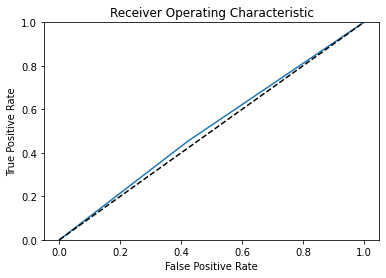

In [11]:
def find_best_tree_model(upper_depth, upper_leaf):
    best_model = None
    best_f1 = -1
    
    for depth in range(1, upper_depth + 1):
        for leaf in range(1, upper_leaf + 1):
            model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth, min_samples_leaf=leaf) 
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            
            f1 = f1_score(y_val, y_pred)
            
            if f1 > best_f1:
                best_f1 = f1
                best_model = model
    
    return best_model

best_tree_model = find_best_tree_model(80, 30)

run_model(best_tree_model, X_train, X_test, y_train, y_test)

## Random Forest

AUC is:  0.5874125874125874
              precision    recall  f1-score   support

           0       0.78      0.54      0.64        26
           1       0.37      0.64      0.47        11

    accuracy                           0.57        37
   macro avg       0.57      0.59      0.55        37
weighted avg       0.66      0.57      0.59        37

Confusion Matrix: 
 [[14 12]
 [ 4  7]]


RandomForestClassifier(random_state=42)

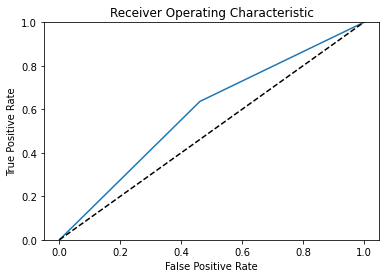

In [12]:
def find_best_forest_model(n_estimators):
    best_model = None
    best_f1 = -1
    
    for estimator in range(1, n_estimators + 1):
        model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=n_estimators) 
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        f1 = f1_score(y_val, y_pred)

        if f1 > best_f1:
            best_f1 = f1
            best_model = model
    
    return best_model

best_forest_model = find_best_forest_model(100)

run_model(best_forest_model, X_train, X_test, y_train, y_test)

## SVM with grid search

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    3.0s


AUC is:  0.5384615384615384
              precision    recall  f1-score   support

           0       1.00      0.08      0.14        26
           1       0.31      1.00      0.48        11

    accuracy                           0.35        37
   macro avg       0.66      0.54      0.31        37
weighted avg       0.80      0.35      0.24        37

Confusion Matrix: 
 [[ 2 24]
 [ 0 11]]
Best SVM parameters: {'C': 1, 'degree': 3, 'kernel': 'poly'}


[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    4.2s finished


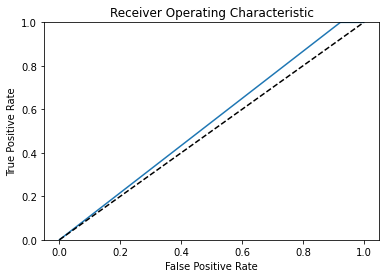

In [13]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100]},
                    {'kernel': ['poly'], 'degree': [3, 4, 5], 'C': [1, 10, 100]},
                    {'kernel': ['linear'], 'C': [1, 10, 100]}]

svm_model_cv = GridSearchCV(SVC(), tuned_parameters, cv=10, scoring='f1', verbose=1, n_jobs=4)

best_svm_model = run_model(svm_model_cv, X_train_val_norm, X_test_norm, y_train_val, y_test)
print(f"Best SVM parameters: {best_svm_model.best_params_}")

Based on the output, the model appears to maximize the recall rates with a small degree of precision for the positive class in order to obtain the most optimal `f1 score`. The model probably uses a soft decision boundary that is overfitted to the training data, resulting in any unseen data point being disproportionately classified as depressed cases (with label = 1). For this reason, SVM is not a good option. Also, it does not provide probability outcomes as a measure of its confidence level, which would be valuable for professionals to evaluate in a medical situation.

## Neural Networks 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(100, dropout=0.2, recurrent_dropout=0.2)`
  after removing the cwd from sys.path.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 128)         1004544   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               91600     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 1,122,257
Trainable params: 1,122,257
Non-trainable params: 0
_________________________________________________________________
None


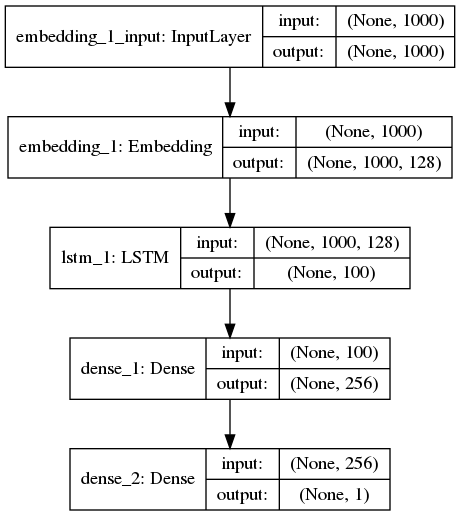

In [14]:
lstm_model = Sequential()

lstm_model.add(Embedding(vocab_size, 128, input_length=maxlen, dropout=0.2))
lstm_model.add(LSTM(100, dropout_U = 0.2, dropout_W = 0.2))
lstm_model.add(Dense(256, bias_initializer=Constant(0.01)))
lstm_model.add(Dense(1, bias_initializer=Constant(0.01), activation="sigmoid"))

print(lstm_model.summary())
plot_model(lstm_model, to_file='lstm_classification.png', show_shapes=True)

In [15]:
batch_size = 32
es = EarlyStopping(monitor='val_loss', mode='min', patience=10)

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
checkpoint_filepath = 'lstm_model.h5'

checkpoint =  ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', mode='min', save_best_only=True)

lstm_model.fit(X_train, y_train, batch_size=batch_size, epochs=50, validation_data=(X_val, y_val), callbacks=[es, checkpoint])
loss, acc = lstm_model.evaluate(X_test, y_test, batch_size=batch_size)

lstm_model = load_model(checkpoint_filepath)

print('Test loss:', loss)
print('Test accuracy:', acc)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 70 samples, validate on 18 samples
Epoch 1/50
70/70 [==============================] - 5s 78ms/step - loss: 0.6920 - accuracy: 0.5429 - val_loss: 0.6965 - val_accuracy: 0.4444
Epoch 2/50
70/70 [==============================] - 4s 61ms/step - loss: 0.6869 - accuracy: 0.5571 - val_loss: 0.7011 - val_accuracy: 0.4444
Epoch 3/50
70/70 [==============================] - 4s 63ms/step - loss: 0.6783 - accuracy: 0.5143 - val_loss: 0.7047 - val_accuracy: 0.4444
Epoch 4/50
70/70 [==============================] - 4s 61ms/step - loss: 0.6591 - accuracy: 0.6000 - val_loss: 0.7135 - val_accuracy: 0.4444
Epoch 5/50
70/70 [==============================] - 5s 65ms/step - loss: 0.6249 - accuracy: 0.6429 - val_loss: 0.7283 - val_accuracy: 0.3889
Epoch 6/50
70/70 [==============================] - 4s 63ms/step - loss: 0.5363 - accuracy: 0.8000 - val_loss: 0.7558 - val_accuracy: 0.4444
Epoch 7/50
70/70 [==============================] - 5s 68ms/step - loss: 0.4032 - accuracy: 0.8857 - val_loss:

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0] 

AUC is:  0.4807692307692308
              precision    recall  f1-score   support

           0       0.69      0.96      0.81        26
           1       0.00      0.00      0.00        11

    accuracy                           0.68        37
   macro avg       0.35      0.48      0.40        37
weighted avg       0.49      0.68      0.57        37

Confusion Matrix: 
 [[25  1]
 [11  0]]


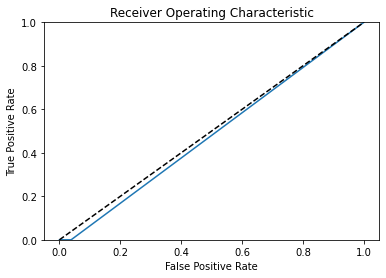

In [16]:
predictions = lstm_model.predict(X_test)
y_pred = np.where(predictions > 0.5, 1, 0).flatten()

print(y_pred)
print(y_test.to_numpy(), '\n')

evaluate_on_training_set(y_test, y_pred)